# Replica project

### Iconographic subset

Creates subset, stores pre-pooling embeddings for items in subset and for 5 most similar ones to each using embeddings, attempts clustering and mapper.

In [35]:
# loading the metadata
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from scipy import sparse
import pickle
import sys

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import random


sys.path.insert(0, "../model/")
from utils import *
from spatial_reranking import sim_matrix_rerank, make_embds_pooled, match_feature_maps_simple

sys.path.insert(0, "../cluster_visualization/")
from utils_clusters import *


path = '/home/guhennec/scratch/2021_Cini/TopologicalAnalysis_Cini/data/'
data_dir = '/scratch/students/schaerf/'
replica_dir = '/mnt/project_replica/datasets/cini/'
wga_dir = '/mnt/project_replica/datasets/WGA/'

path = '../data/'
data_dir = '../data/'
replica_dir = '../data/'
wga_dir = '../data/'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
#metadata = pd.read_csv(path + 'Cini_20210811.csv', sep=';')
#metadata['path'] = metadata['Drawer'].astype(str) + '/' + metadata['Drawer'].astype(str) + '_' + metadata['ImageNumber'].astype(str) + '.jpg'
metadata = pd.read_csv(data_dir + 'dedup_data.csv').drop(columns=['Unnamed: 0', 'level_0'])
metadata.head(5)

C:\Users\ludov\AppData\Local\Temp/ipykernel_4860/2466698109.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(data_dir + 'dedup_data.csv').drop(columns=['Unnamed: 0', 'level_0'])


,uid,uid_connection,cluster,index,Drawer,ImageNumber,Author,Description,AuthorOriginal,AuthorULANLabel,...,AuthorDeathCity,CardboardURL,ImageURL,img1,img2,type,annotated,uid2,set,path
0,00000763d00845d7aa8f796fa3e86e20,c8ac0f0ea2524e74a8b90c92138260a5,4041,0,61A,632,MARESCALCHI Pietro,Madonna in trono e Santi.,"MAKESCALCHI, Pietro.","Marascalchi, Pietro de'",...,Feltre,https://dhlabsrv4.epfl.ch/iiif_cini/61A%2F61A_...,https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...,00000763d00845d7aa8f796fa3e86e20,3e1be39c07bd4203848d7ebe44db3528,DUPLICATE,2018-07-19 17:17:46.960437+00:00,61A/61A_632.jpg,NaN,61A/61A_632.jpg
1,00001c888748454ea4ecf8997f902f1f,Not uid connection,00001c888748454ea4ecf8997f902f1f,3,87A,507,SCULTORE SEC XVII,Colonna . Part.,SCULTORE SEC. XVII,NaN,...,NaN,https://dhlabsrv4.epfl.ch/iiif_cini/87A%2F87A_...,https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...,NaN,NaN,NaN,NaN,87A/87A_507.jpg,NaN,87A/87A_507.jpg
2,000036a6440344f89e0f0e120e962f88,Not uid connection,000036a6440344f89e0f0e120e962f88,4,1C,484,TIZIANO Vecellio,Giovane guerriero. 272x178,TIZIANO.,Titian,...,Venice,https://dhlabsrv4.epfl.ch/iiif_cini/1C%2F1C_48...,https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...,NaN,NaN,NaN,NaN,1C/1C_484.jpg,NaN,1C/1C_484.jpg
3,000092c815b6453eb6f37ccabbc8689d,Not uid connection,000092c815b6453eb6f37ccabbc8689d,5,42C,694,BOSCHINI Marco,Pag. 664,"BOSCHINI, Marco.","Boschini, Marco",...,Venice,https://dhlabsrv4.epfl.ch/iiif_cini/42C%2F42C_...,https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...,NaN,NaN,NaN,NaN,42C/42C_694.jpg,NaN,42C/42C_694.jpg
4,0000b1a1cf3843619edb853fa03a2d5d,Not uid connection,0000b1a1cf3843619edb853fa03a2d5d,6,96A,336,CATTANEO Danese,Allegoria.,"CATTANEO, Danese.","Cattaneo, Danese",...,NaN,https://dhlabsrv4.epfl.ch/iiif_cini/96A%2F96A_...,https://dhlabsrv4.epfl.ch/iiif_replica/cini%2F...,NaN,NaN,NaN,NaN,96A/96A_336.jpg,NaN,96A/96A_336.jpg


In [4]:
# in jeanne's code
# with open(path + 'save_link_data_2018_08_02.pkl', 'rb') as f:
#     morpho_graph_complete = pickle.load(f)

# # contains uid	img1	img2	type	annotated
# morpho_graph_complete.head()

In [3]:
madonnas = metadata[metadata['Description'].fillna('').str.contains('Madonna col Bambino')]#['Description']
madonnas.shape

(2074, 47)

In [4]:
# positives = get_train_test_split(madonnas, morpho_graph_complete)
# positives = positives.groupby('uid_connection').first().reset_index()
# print(positives.shape)
# positives.head()

In [5]:
train = madonnas[madonnas['set'].isin(['train', 'val', 'test'])]
train.shape

(274, 47)

## Getting set of images to store embeddings of

In [19]:
# embeddings = np.load(
#                     #data_dir + 'resnext-101_avg_480' + ".npy",
#                     data_dir + 'embeddings/resnext-101_epoch_314-04-2022_23:25:29.npy',
#                     allow_pickle=True,
#                 )        

In [6]:
# tree, reverse_map = make_tree_orig(embeddings, reverse_map=True)

In [6]:
with open(data_dir + 'uid2path.pkl', 'rb') as outfile:
        uid2path = pickle.load(outfile)


In [8]:
# sim_arts = []
# for i, artwork in enumerate(madonnas.iterrows()):
#     if artwork[1]['uid'] in reverse_map.values():
#         sim_arts.append(find_most_similar_orig(artwork[1]["uid"], tree, embeddings, reverse_map, n=6))

            

In [9]:
# sim_arts = list(set([x for xx in sim_arts for x in xx]))
# print(len(sim_arts))
# sim_arts

In [10]:
# final = list(set(sim_arts + list(madonnas['uid'])))
# final
# print(len(final))

In [7]:
# with open(data_dir + 'list_iconography.pkl', 'wb') as oufile:
#     pickle.dump(final, oufile)
    

with open(data_dir + 'list_iconography.pkl', 'rb') as infile:
    final = pickle.load(infile)


In [12]:
#make_embds_pooled()  #store also for normal embeddings
# make new metadata file with all madonnas (so include also the 5 most similar ones that are now in files)

In [13]:
# embeds = np.load(data_dir + 'embedding_no_pool/madonnas_pooled.npy', allow_pickle=True)
# print(embeds.shape)

In [15]:
# embeds = np.load(data_dir + 'embedding_no_pool/madonnas.npy', allow_pickle=True)
# print(embeds.shape)

In [17]:
# match_feature_maps_simple(embeds[4, 1], embeds[7, 1], norm=True)

In [21]:
# embeds.shape

(2654, 2)

In [14]:
# sim_mat, index = sim_matrix_rerank(embeds)
# np.save(data_dir + 'embedding_no_pool/' 'similarities_madonnas.npy', sim_mat)

In [8]:
sim_mat = np.load(data_dir + 'similarities_madonnas_500.npy', allow_pickle=True) #embedding_no_pool/

In [9]:
diff_mat = np.round(1 - sim_mat, 3)
diff_mat

array([[0.   , 0.667, 0.627, ..., 0.62 , 0.522, 0.39 ],
       [0.667, 0.   , 0.439, ..., 0.707, 0.466, 0.472],
       [0.549, 0.439, 0.   , ..., 0.64 , 0.283, 0.594],
       ...,
       [0.62 , 0.724, 0.72 , ..., 0.012, 0.724, 0.655],
       [0.522, 0.466, 0.283, ..., 0.69 , 0.   , 0.704],
       [0.39 , 0.679, 0.688, ..., 0.691, 0.722, 0.   ]])

In [58]:
#sim_mat = StandardScaler().fit_transform(sim_mat)
db = DBSCAN(eps=0.1, min_samples=2, metric='precomputed').fit(diff_mat)

In [65]:
labels = final[:500]
classes = db.labels_

clusters = pd.DataFrame({'uid':labels, 'cluster':classes})
clusters['cluster'].value_counts(), clusters['cluster'].nunique()

(-1     441
  11      6
  12      4
  6       4
  15      4
  3       3
  5       3
  19      3
  14      2
  21      2
  20      2
  18      2
  17      2
  16      2
  1       2
  13      2
  2       2
  0       2
  10      2
  9       2
  8       2
  7       2
  4       2
  22      2
 Name: cluster, dtype: int64,
 24)

In [67]:
clusters['path'] = clusters['uid'].apply(lambda x: uid2path[x])
clusters.head()

,uid,cluster,path
0,7ca6585c152b47fcbba64ec11915f11a,-1,25A/25A_292.jpg
1,9c64efe6c48e412ba37259d282087112,-1,112A/112A_605.jpg
2,b5b9eed8509e421480f10018bfdb6c8b,0,62B/62B_315.jpg
3,103a9d19f9d7454a8565ff99c2a21d47,-1,14B/14B_83.jpg
4,61948d265f8a430483593ed41dffa02d,1,123A/123A_411.jpg


13


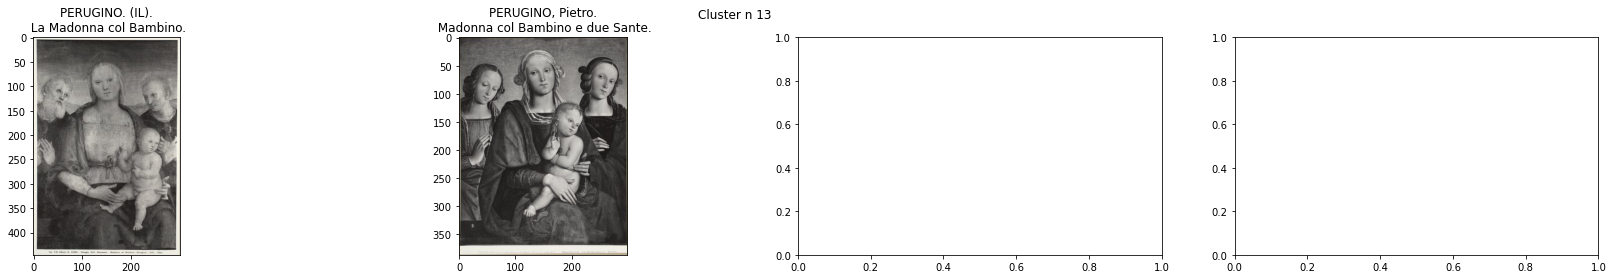

In [80]:
i = random.randint(0, 23)
print(i)
draw_clusters(i, clusters, metadata)

Estimated number of clusters: 437
Estimated number of noise points: 0


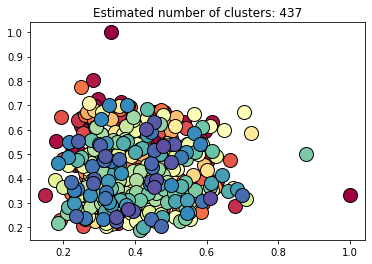

In [26]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
#print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(sim_mat, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = sim_mat[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = sim_mat[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [ ]:
# if done only on annotated data

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)